In [50]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [51]:
data_clean = pd.read_csv("../data/data.csv", index_col=0)

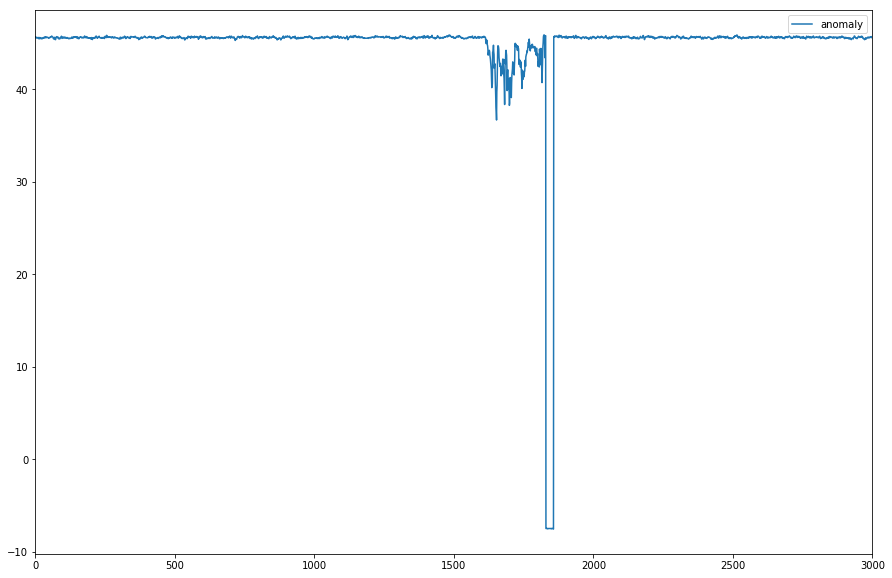

In [52]:
data_clean.plot()

In [55]:
data = data_clean

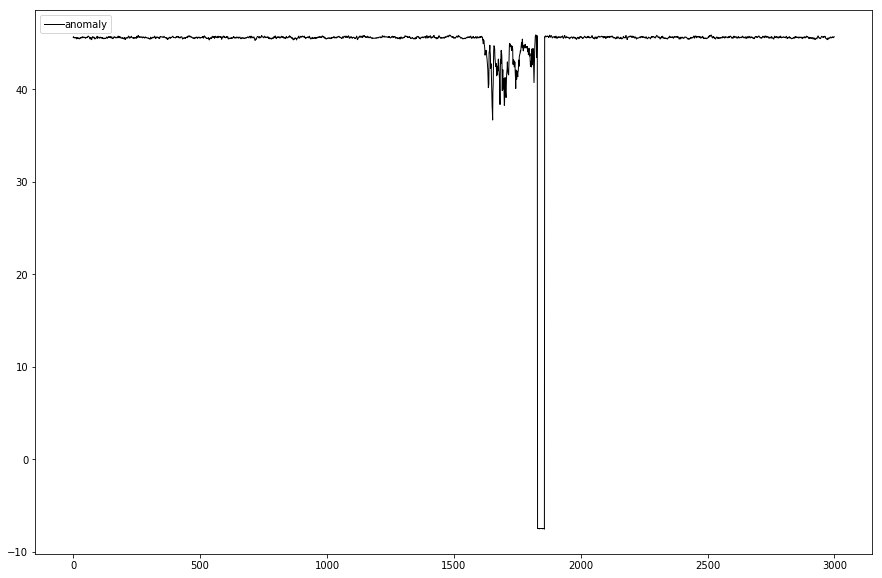

In [56]:
fig, axes = plt.subplots(nrows=len(data.columns))
index = list(data.columns).index(data.columns[0])
x_observed = data.index
y_observed = data.loc[:,data.columns[0]]
axes.plot(x_observed, y_observed, label=data.columns[0], color='k', linewidth=1)
axes.legend(loc='upper left', handletextpad=0)

In [70]:
rng = np.random.RandomState(1)
model = TRCRP_Mixture(chains=8, lag=200, variables=data.columns, rng=rng)
model.incorporate(data)
model.resample_all(seconds=20)
model.resample_hyperparameters(seconds=20)
probes = model.dataset.index
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

Completed: 6 iterations in 20.570111 seconds.
Completed: 3 iterations in 22.190848 seconds.
Completed: 5 iterations in 22.282697 seconds.
Completed: 1 iterations in 24.503361 seconds.%
Completed: 0 iterations in 26.793679 seconds.3.97%
Completed: 1 iterations in 33.658461 seconds.======] 168.29%
Completed: 0 iterations in 71.984738 seconds.===============================================================] 359.92%
Completed: 0 iterations in 113.903980 seconds.=============================================================================================================================] 569.52%
Completed: 5 iterations in 20.191938 seconds.
Completed: 2 iterations in 25.299508 seconds.9%
Completed: 3 iterations in 25.788947 seconds.92%
Completed: 2 iterations in 26.167071 seconds..82%
Completed: 2 iterations in 27.967074 seconds.39.82%
Completed: 1 iterations in 30.879385 seconds.==] 154.39%
Completed: 2 iterations in 33.675326 seconds.======] 168.36%
Completed: 1 iterations in 516.405865 sec

In [71]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [72]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

(0, 2999)

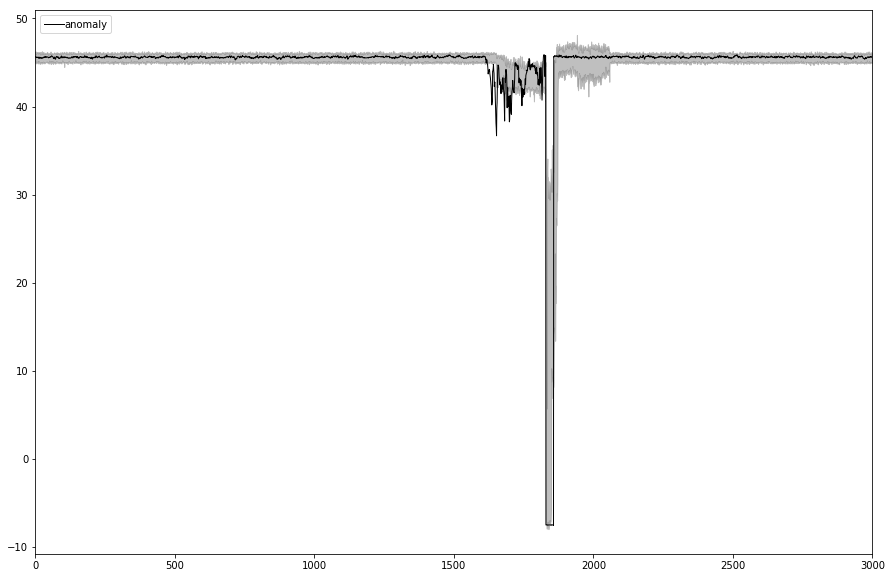

In [73]:
fig, axes = plt.subplots(nrows=len(data.columns))
plot_predictions(samples, data.columns[0], axes)
axes.set_xlim([min(probes), max(probes)])

(0, 2999)

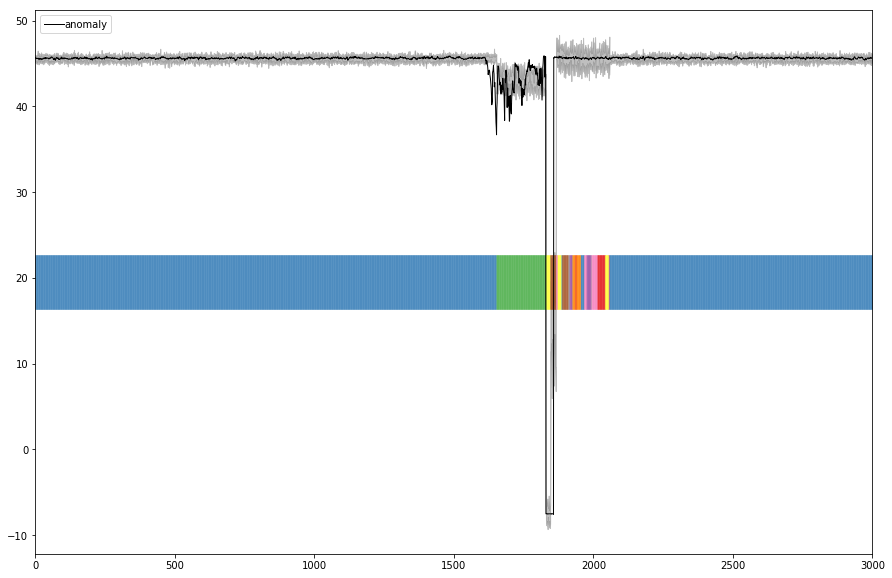

In [74]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples_chain,data.columns[0], axes, states_from_chain=chain)
axes.set_xlim([min(probes), max(probes)])

In [75]:
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

(0, 3098)

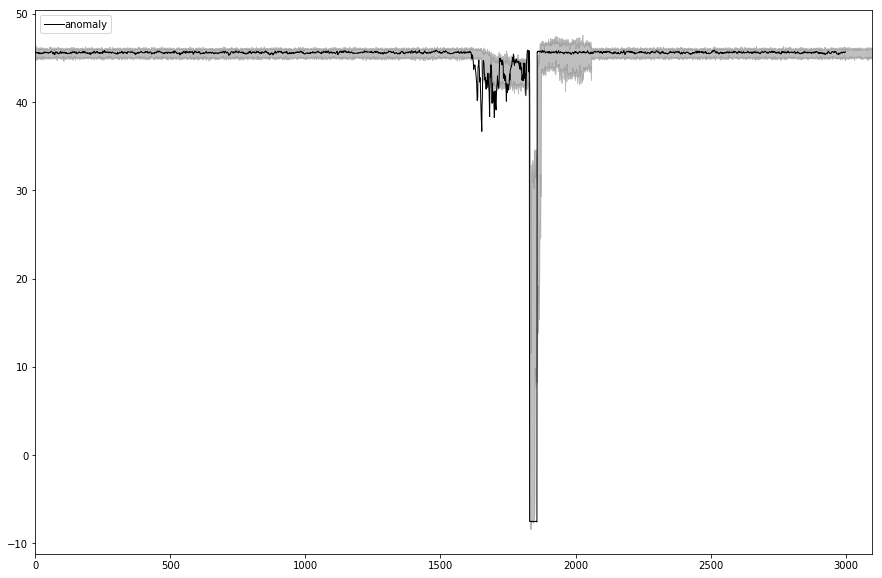

In [76]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples, data.columns[0], axes)
axes.set_xlim([min(probes), max(probes)])